# Summary Evaluation Demo

End-to-end evaluation of financial/business summaries using:
- **ROUGE**: N-gram overlap metrics
- **BERTScore**: Semantic similarity using local RoBERTa-large model
- **Stylometric Analysis**: Writing style matching to personas

## Requirements

```bash
# Local RoBERTa-large model (1.4GB)
python setup_roberta.py

# Verify
ls roberta-large/
```

## Setup and Imports

In [1]:
import json
import pandas as pd
import numpy as np
from pathlib import Path
import os
import warnings
warnings.filterwarnings('ignore')

from src.io_utils import load_all_records
from src.content_metrics import ContentMetricsCalculator
from src.style_features import StyleAnalyzer
from rouge_score import rouge_scorer

print("✓ Imports successful")

✓ Imports successful


## Configure Local Model

Set environment variables to use local `roberta-large/` directory:

In [2]:
# Force offline mode - prevents HuggingFace downloads
os.environ['HF_HUB_OFFLINE'] = '1'
os.environ['TRANSFORMERS_OFFLINE'] = '1'

# Point to local model directory
roberta_dir = Path("roberta-large")
os.environ['TRANSFORMERS_CACHE'] = str(roberta_dir.parent.absolute())
os.environ['HF_HOME'] = str(roberta_dir.parent.absolute())

if roberta_dir.exists() and (roberta_dir / "config.json").exists():
    print(f"✓ Local RoBERTa model found: {roberta_dir.absolute()}")
    print(f"  Size: {sum(f.stat().st_size for f in roberta_dir.glob('**/*') if f.is_file()) / 1e9:.1f}GB")
    print(f"  Offline mode: Enabled")
else:
    print(f"⚠ Local model not found. Run: python setup_roberta.py")

✓ Local RoBERTa model found: /Users/dimitermilushev/code/projects/rogue/roberta-large
  Size: 1.4GB
  Offline mode: Enabled


## Load Data

In [3]:
# Load all JSON files from data/ directory
records = load_all_records('data')

print(f"✓ Loaded {len(records)} records")
print(f"\nPersonas: {set(r['persona'] for r in records)}")
print(f"Sectors: {set(r['sector'] for r in records)}")

✓ Loaded 9 records

Personas: {'formal_analyst'}
Sectors: {'Consumer Goods', 'Automotive', 'Utilities', 'Economics', 'Tobacco', 'Healthcare', 'Technology', 'Semiconductors'}


## Examine Example

In [4]:
# Select example to analyze
example = records[0]

print("📰 Title:", example['document_title'])
print("🎭 Persona:", example['persona'])
print("🤖 Model:", example['model_used'])
print("\n" + "="*80)
print("\n📄 SOURCE (first 300 chars):")
print(example['document_content'][:300] + "...")
print("\n" + "="*80)
print("\n🎯 EXPECTED SUMMARY:")
print(example['expected_summary'][:400] + "...")
print("\n" + "="*80)
print("\n🤖 GENERATED SUMMARY:")
print(example['generated_summary'][:400] + "...")

📰 Title: Amazon Web Services: Q4 results show reaccelerating growth driven by AI workloads
🎭 Persona: formal_analyst
🤖 Model: gpt-4o


📄 SOURCE (first 300 chars):
Amazon Web Services (AWS) reported Q4 2024 revenue of $27.5 billion, up 19.3% year-over-year (16.9% constant currency), marking acceleration from 12.3% growth in Q1. Operating income reached $10.4 billion with operating margin of 37.8%, up from 29.8% a year ago, demonstrating strong operational leve...


🎯 EXPECTED SUMMARY:
AWS reported Q4 revenue of $27.5B (+19.3% YoY, +16.9% constant currency), accelerating from Q1's 12.3% growth. Operating income reached $10.4B with margin of 37.8% (up from 29.8% YoY), showing strong leverage. Growth drivers: (1) GenAI workloads ~$2.5B quarterly revenue (+140% YoY), (2) optimization headwinds abating, (3) new enterprise wins. AWS's AI advantage includes custom silicon (Trainium, I...


🤖 GENERATED SUMMARY:
AWS Q4 revenue hit $27.5B (+19.3% YoY), reaccelerating from 12.3% in Q1. Operating i

## ROUGE Metrics

Measures n-gram overlap between generated and expected summaries.

In [5]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeLsum'], use_stemmer=True)

scores = scorer.score(example['expected_summary'], example['generated_summary'])

print("📊 ROUGE Scores:\n")
for metric_name, metric_scores in scores.items():
    print(f"{metric_name.upper()}:")
    print(f"  Precision: {metric_scores.precision:.4f}")
    print(f"  Recall:    {metric_scores.recall:.4f}")
    print(f"  F1:        {metric_scores.fmeasure:.4f}\n")

📊 ROUGE Scores:

ROUGE1:
  Precision: 0.6772
  Recall:    0.7868
  F1:        0.7279

ROUGE2:
  Precision: 0.3503
  Recall:    0.4074
  F1:        0.3767

ROUGELSUM:
  Precision: 0.5823
  Recall:    0.6765
  F1:        0.6259



## BERTScore

Semantic similarity using embeddings from local RoBERTa-large model.

In [6]:
try:
    import bert_score
    
    print("Calculating BERTScore with local RoBERTa-large...\n")
    
    P, R, F1 = bert_score.score(
        [example['generated_summary']], 
        [example['expected_summary']],
        model_type='roberta-large',
        lang='en',
        rescale_with_baseline=True,  # Important: normalizes scores
        verbose=False
    )
    
    print(f"📊 BERTScore (IDF weighted + baseline rescaled):")
    print(f"  Precision: {P.item():.4f}")
    print(f"  Recall:    {R.item():.4f}")
    print(f"  F1:        {F1.item():.4f}")
    
    bertscore_f1 = F1.item()
    
    print(f"\n💡 F1 = {bertscore_f1:.4f} indicates ", end="")
    if bertscore_f1 > 0.85:
        print("excellent semantic similarity")
    elif bertscore_f1 > 0.7:
        print("good semantic similarity")
    elif bertscore_f1 > 0.5:
        print("fair semantic similarity")
    else:
        print("poor semantic similarity")
    
    print("\n✓ Using local model (no downloads)")
    bertscore_available = True
    
except Exception as e:
    print(f"⚠ BERTScore failed: {e}")
    bertscore_available = False
    bertscore_f1 = None

Calculating BERTScore with local RoBERTa-large...

📊 BERTScore (IDF weighted + baseline rescaled):
  Precision: 0.6098
  Recall:    0.6553
  F1:        0.6331

💡 F1 = 0.6331 indicates fair semantic similarity

✓ Using local model (no downloads)


## Stylometric Analysis

In [7]:
# Initialize style analyzer
persona_config = {
    'personas': {
        'formal_analyst': 'data/personas/formal_analyst.txt',
        'journalist': 'data/personas/journalist.txt',
        'enthusiast': 'data/personas/enthusiast.txt'
    }
}
style_analyzer = StyleAnalyzer(persona_config)

# Build persona centroids
print("Building persona centroids...")
centroids = style_analyzer.build_persona_centroids(force_rebuild=True)
print(f"✓ Built centroids for {len(centroids)} personas\n")

# Calculate similarity
print(f"Summary persona: {example['persona']}")
print(f"\n📊 Style Similarity to Each Persona:\n")

similarities = {}
for persona_id in centroids.keys():
    similarity = style_analyzer.calculate_style_similarity(example['generated_summary'], persona_id)
    similarities[persona_id] = similarity
    marker = "✓" if persona_id == example['persona'] else " "
    print(f"  {marker} {persona_id:20s}: {similarity:.4f}")

best_match = max(similarities, key=similarities.get)
print(f"\n🏆 Best match: {best_match}", end="")
if best_match == example['persona']:
    print(" ✓ Correct!")
else:
    print(f" ✗ (expected {example['persona']})")

Building persona centroids...
✓ Built centroids for 3 personas

Summary persona: formal_analyst

📊 Style Similarity to Each Persona:

  ✓ formal_analyst      : 0.8184
    journalist          : 0.8185
    enthusiast          : 0.6930

🏆 Best match: journalist ✗ (expected formal_analyst)


## Full Evaluation

Run evaluation on all records:

In [10]:
results = []

print(f"Evaluating {len(records)} records...\n")

# Initialize calculators
content_config = {
    'use_rouge': True,
    'use_bertscore': bertscore_available,
    'bertscore_model': 'roberta-large',
    'use_bleurt': False
}
content_calc = ContentMetricsCalculator({'content': content_config})

for i, rec in enumerate(records, 1):
    print(f"  [{i}/{len(records)}] {rec['document_title'][:50]}...")

    # Content metrics (using bert_score for BERTScore)
    rouge_scores = scorer.score(rec['expected_summary'], rec['generated_summary'])

    if bertscore_available:
        import bert_score
        _, _, F1 = bert_score.score(
            [rec['generated_summary']],
            [rec['expected_summary']],
            model_type='roberta-large',
            lang='en',  # Required when rescale_with_baseline=True
            rescale_with_baseline=True,
            verbose=False
        )
        bertscore_val = F1.item()
    else:
        bertscore_val = None

    # Style similarity
    style_sim = style_analyzer.calculate_style_similarity(
        rec['generated_summary'],
        rec['persona']
    )

    # Calculate content quality (weighted average)
    rouge_lsum = rouge_scores['rougeLsum'].fmeasure
    if bertscore_val:
        content_quality = 0.4 * rouge_lsum + 0.6 * bertscore_val
    else:
        content_quality = rouge_lsum

    # Overall quality (70% content + 30% style)
    style_score = style_sim if style_sim is not None else 0.0
    overall_quality = (0.7 * content_quality) + (0.3 * style_score)

    results.append({
        'file': rec['_source_file'],
        'title': rec['document_title'][:40],
        'sector': rec['sector'],
        'persona': rec['persona'],
        'model': rec['model_used'],
        'rouge1_f': rouge_scores['rouge1'].fmeasure,
        'rouge2_f': rouge_scores['rouge2'].fmeasure,
        'rougeLsum_f': rouge_scores['rougeLsum'].fmeasure,
        'bertscore_f1': bertscore_val,
        'style_similarity': style_sim,
        'content_quality': content_quality,
        'overall_quality': overall_quality
    })

df = pd.DataFrame(results)
print("\n✓ Evaluation complete!")

Evaluating 9 records...

  [1/9] Amazon Web Services: Q4 results show reacceleratin...
  [2/9] Federal Reserve November FOMC Decision: Policy rat...
  [3/9] JPMorgan Economic Outlook 2026: Soft landing scena...
  [4/9] NextEra Energy: Renewable capacity expansion accel...
  [5/9] NVIDIA Corporation: Q324 earnings beat driven by d...
  [6/9] Pfizer Inc: Pipeline update shows progress in onco...
  [7/9] Procter & Gamble: Premium positioning strategy dri...
  [8/9] RLX Technology: Q325 strong beat across lines driv...
  [9/9] Tesla Inc: Q4 2024 results show delivery growth bu...

✓ Evaluation complete!


## Results Summary

In [11]:
print("\n📊 EVALUATION RESULTS\n")
print("="*80)

# Display key columns
display_cols = ['title', 'persona', 'overall_quality', 'rouge1_f', 'rougeLsum_f']
if bertscore_available:
    display_cols.insert(5, 'bertscore_f1')
display_cols.append('style_similarity')

print(df[display_cols].to_string(index=False))

print("\n" + "="*80)
print("\n📈 SUMMARY STATISTICS\n")

print(f"Overall Quality (70% content + 30% style):")
print(f"  Mean: {df['overall_quality'].mean():.4f} ± {df['overall_quality'].std():.4f}")
print(f"  Min:  {df['overall_quality'].min():.4f}")
print(f"  Max:  {df['overall_quality'].max():.4f}")

print(f"\nContent Metrics:")
print(f"  ROUGE-1 F1:    {df['rouge1_f'].mean():.4f}")
print(f"  ROUGE-Lsum F1: {df['rougeLsum_f'].mean():.4f}")
if bertscore_available and df['bertscore_f1'].notna().any():
    print(f"  BERTScore F1:  {df['bertscore_f1'].mean():.4f}")

print(f"\nStyle Fidelity:")
print(f"  Similarity: {df['style_similarity'].mean():.4f}")

print(f"\nBy Persona:")
for persona in sorted(df['persona'].unique()):
    persona_df = df[df['persona'] == persona]
    print(f"  {persona:20s}: {len(persona_df):2d} items")
    print(f"    Overall:  {persona_df['overall_quality'].mean():.3f}")
    print(f"    Content:  {persona_df['content_quality'].mean():.3f}")
    print(f"    Style:    {persona_df['style_similarity'].mean():.3f}")


📊 EVALUATION RESULTS

                                   title        persona  overall_quality  rouge1_f  rougeLsum_f  bertscore_f1  style_similarity
Amazon Web Services: Q4 results show rea formal_analyst         0.686650  0.727891     0.625850      0.633076          0.818401
Federal Reserve November FOMC Decision:  formal_analyst         0.565529  0.626506     0.559036      0.392356          0.814032
JPMorgan Economic Outlook 2026: Soft lan formal_analyst         0.668617  0.732877     0.623288      0.558319          0.865342
NextEra Energy: Renewable capacity expan formal_analyst         0.650925  0.685864     0.612565      0.540657          0.841102
NVIDIA Corporation: Q324 earnings beat d formal_analyst         0.561767  0.539683     0.463492      0.414300          0.859945
Pfizer Inc: Pipeline update shows progre formal_analyst         0.666069  0.709677     0.567742      0.566041          0.897880
Procter & Gamble: Premium positioning st formal_analyst         0.682066  0.74924

## Visualization


✓ Saved visualization to outputs/eval_viz.png


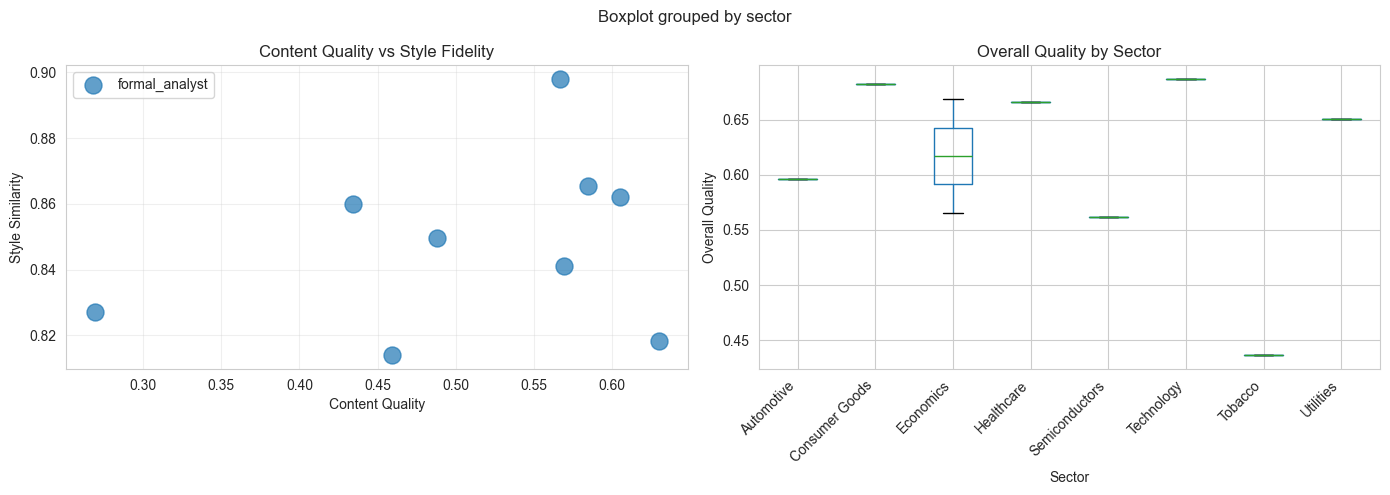

In [12]:
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Content vs Style
    for persona in df['persona'].unique():
        persona_df = df[df['persona'] == persona]
        axes[0].scatter(persona_df['content_quality'], persona_df['style_similarity'], 
                       label=persona, alpha=0.7, s=150)
    axes[0].set_xlabel('Content Quality')
    axes[0].set_ylabel('Style Similarity')
    axes[0].set_title('Content Quality vs Style Fidelity')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Overall quality by sector
    df.boxplot(column='overall_quality', by='sector', ax=axes[1])
    axes[1].set_title('Overall Quality by Sector')
    axes[1].set_ylabel('Overall Quality')
    axes[1].set_xlabel('Sector')
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('outputs/eval_viz.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved visualization to outputs/eval_viz.png")
    plt.show()
    
except ImportError:
    print("⚠ Matplotlib not available. Install with: pip install matplotlib seaborn")

## Save Results

In [13]:
# Save detailed results
output_dir = Path('outputs')
output_dir.mkdir(exist_ok=True)

output_file = output_dir / 'eval_results.csv'
df.to_csv(output_file, index=False)
print(f"✓ Saved results to {output_file}")

print("\n" + "="*80)
print("EVALUATION COMPLETE")
print("="*80)

✓ Saved results to outputs/eval_results.csv

EVALUATION COMPLETE
